# Installation 

from the root kmcluster folder you want to run the 'pip install -e .' then you will be able to run the box below without errors

In [1]:
import numpy as np
from kmcluster.core.kmc import kmc
from kmcluster.core.transition_conditions import rfkmc, rkmc
from kmcluster.core.intialize import random_init, boltz, global_minimum_only, selected
from kmcluster.core.data import pull_json

from kmcluster.core.viz import (
    plot_top_n_states,
    plot_states,
    graph_trajectories_static,
    graph_trajectories_dynamic,
    communities_static,
    compute_state_counts,
)

# Parameters 

you can either create a dictionary manually or import a json using "pull_json" 

In [2]:
time_end = 100  # time stop condition
steps = 100  # number of steps
size = 100  # number of independet trajectories
n_states = 10  # number of states
energies = [0, 1.0, 1.0, -1.0]  # list of energies
init_dict = {
    0: 0.5,
    1: 0.5,
}  # dictionary of custom proportions to start with ({state:proportion,...})
temp_boltz = 1.0  # temperature for boltzmann distribution + kmc
temp_sample = 1.0  # temp for sampling kmc
energies_two_states = [[0.0, 0.1], [0.01, 0.0]]
energies_four_states_sink = np.array(
    [
        [0.0, 0.0, 0.0, 0.1],
        [0.0, 0.0, 0.0, 0.1],
        [0.0, 0.0, 0.0, 0.1],
        [0.0, 0.0, 0.0, 0.0],
    ]
)
energies_four_sym = np.array(
    [
        [0.0, 10.1, 0.0, 0.0],
        [0.0, 0.0, 1.1, 0.0],
        [0.0, 0.0, 0.0, 1.1],
        [1.1, 0.0, 0.0, 0.0],
    ]
)
rates_as_sparse = []

parameters = {
    "time": time_end,
    "steps": steps,
    "size": size,
    "n_states": n_states,
    "energies": energies,
    "energies": energies_four_sym.tolist(),
    "draw_method": "rfkmc",
    "init_method": "random_init",
    #'draw_obj': rfkmc(rates_four_sym),
    #'init_obj': random_init(size, 4),
    "t_boltz": 10,
    "init_state_proportion": {0: 0.5, 1: 0.5},
}


# save parameters as json
# import json
# json.dump(parameters, open('parameters.json', 'w'), indent=4)

# load parameters from json
parameters = pull_json("./parameters.json")

# Initializations

1) boltz - given temp, number of trajectories, and energies initialize
2) global min - give it a list of energies
3) selected - user specified in the format {index of start:proportion, ...}
4) random

In [3]:
# different initalization options
init_boltz = boltz(energies=energies, T=temp_boltz, size=size)
init_global_min = global_minimum_only(energies=energies, size=size)
init_select = selected(size, init_dict, n_states)
init_random = random_init(size, n_states)

# Drawing Criteria: 
Two options are available right now: 
1) rfkmc - rejection free kmc 
2) rkmc - rejection kmc where you input parameter r_0

In [4]:
rfkmc_obj = rfkmc(k_b_t=1.0)
rkmc_obj = rkmc(r_0=1.0, k_b_t=1.0)

# Putting it together in kmc()
You can now construct the kmc object and .run() will run the trajectories. Note that steps != time so you can either set steps or time_stop where time will stop once all trajectories reach a certain time or steps are reached, whichever comes first.

In [8]:
rfkmc_obj = rfkmc(k_b_t=1.0)

init_boltz = boltz(energies=energies, T=temp_boltz, size=10000)

# initialize kmc object
kmc_boltz = kmc(
    time_stop=1000,
    energies=energies_four_sym,
    draw_crit=rfkmc_obj,
    initialization=init_global_min,
    memory_friendly=False
)

# run calcs
kmc_boltz.run(n_steps=10)

100%|██████████| 10/10 [00:00<00:00, 553.69it/s]

In [9]:
# get ur data as a dictionary
kmc_boltz.get_state_dict_at_time_as_pandas(t=0)

,count
3,100
0,0
1,0
2,0


In [7]:
# extract trajectories after run
trajectories = kmc_boltz.trajectories

In [8]:
# get dictionary of states and their proportions at time t
dict_states = kmc_boltz.get_state_dict_at_time(t=0)
# sort dict_states by state
dict_states = {k: v for k, v in sorted(dict_states.items(), key=lambda item: item[0])}
print(dict_states)

{'0': 2237, '1': 844, '2': 848, '3': 6071}


In [8]:
# save trajectories as json as dict in format {time: {state: count...}, time: {state: count...}, ...}
kmc_boltz.save_as_dict(
    "../../reporting/traj_json/trajectories.json", start_time=0, end_time=100, step=1
)

In [9]:
kmc_boltz.save_as_matrix(
    "../../reporting/traj_mat/trajectories", start_time=0, end_time=120, step=1
)

In [10]:
# load npy file
traj_mat = np.load("../../reporting/traj_mat/trajectories.csv.npy")
traj_mat.shape  # (state, time)

(10000, 120)

# Visualizations 

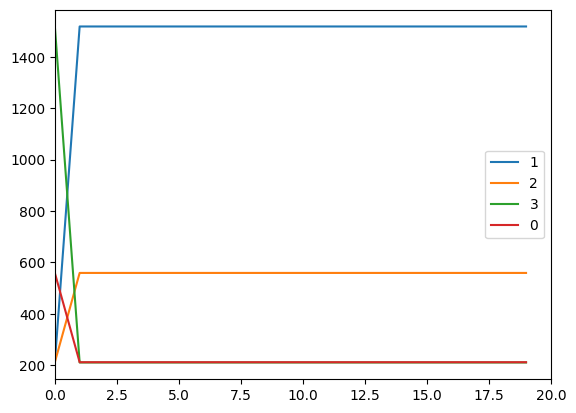

In [9]:
# trajectories object
# n_show = number of states to show
# total_states = total state number of states in the system
# max_time = upper bound of plotting

plot_top_n_states(trajectories, n_show=4, total_states=4, resolution=1, max_time=20)

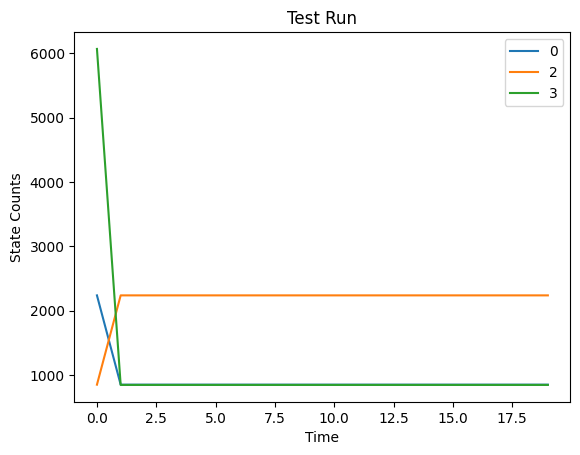

In [10]:
plot_states(
    trajectories,
    states_to_plot=[0, 2, 3],
    resolution=1,
    max_time=20,
    title="Test Run",
    xlabel="Time",
    ylabel="State Counts",
    save=True,
    save_name="../../reporting/plots/test_run.png",
)

[0, 1, 2, 3]
[848, 6071, 2237, 844]


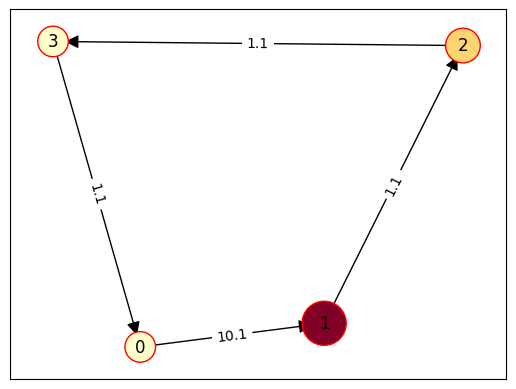

In [11]:
time_slice = 0
pos = graph_trajectories_static(
    trajectories=trajectories, energies=energies_four_sym, time=1, ret_pos=True
)
# TODO: heatmap graph of a given timeframe, -1 is for the last step each traj reached

[0, 1, 2, 3]
[848, 6071, 2237, 844]


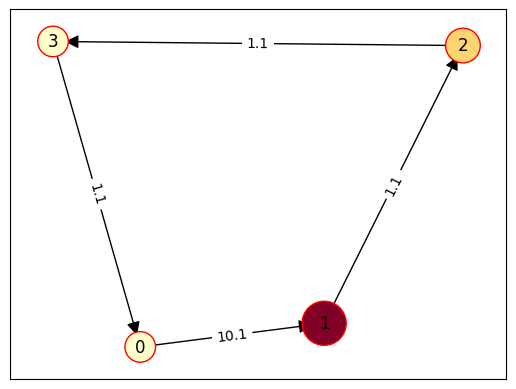

In [12]:
time_slice = 0
graph_trajectories_static(
    trajectories=trajectories, energies=energies_four_sym, time=100, pos=pos
)

In [2]:
# %matplotlib nbagg
graph_trajectories_dynamic(
    trajectories=trajectories,
    energies=energies_four_sym,
    time_max=1000,
    n_states=4,
    file_name="Pt4H1",
)  # TODO: movie of heatmap over time

In [ ]:
# communities_static(trajectories, time = 1000) # TODO: create superbasins of states using community graph algorithms

In [ ]:
# communities(trajectories, max_time = 1000) # TODO: create superbasins of states using community graph algorithms

# Real Data

In [2]:
Pt_H1_links = [
    [0, 1, 0.15],
    [0, 2, 0.61],
    [0, 3, 0.39],
    [2, 4, 0.27],
    [2, 6, 0.50],
    [2, 8, 0.66],
    [3, 8, 0.50],
    [5, 7, 0.52],
    [5, 9, 0.66],
    [5, 6, 0.66],
]
H_H1_links = [
    [0, 6, 0.52],
    [1, 2, 0.28],
    [2, 5, 0.22],
    [3, 5, 0.22],
    [7, 8, 0.15],
    [8, 9, 0.14],
]
Pt4H1_rawE = [
    -17.71720725,
    -17.68531409,
    -17.57336808,
    -17.50640668,
    -17.50097929,
    -17.50887522,
    -17.38155630,
    -17.25580137,
    -17.15164472,
    -17.13649884,
]
H1_E = [Pt4H1_rawE[x] - Pt4H1_rawE[0] for x in range(0, len(Pt4H1_rawE))]

Pt4H1_rev = []
for i in range(0, len(Pt_H1_links)):
    Pt4H1_rev.append(
        [
            Pt_H1_links[i][1],
            Pt_H1_links[i][0],
            round(
                (Pt_H1_links[i][2] + H1_E[Pt_H1_links[i][0]]) - H1_E[Pt_H1_links[i][1]],
                2,
            ),
        ]
    )

# raw energies
Pt4H1_rawE = [
    -17.71720725,
    -17.68531409,
    -17.57336808,
    -17.50640668,
    -17.50097929,
    -17.50887522,
    -17.38155630,
    -17.25580137,
    -17.15164472,
    -17.13649884,
]

# relative energies
H1_E = [Pt4H1_rawE[x] - Pt4H1_rawE[0] for x in range(0, len(Pt4H1_rawE))]

# all the forward barriers
Pt_H1_links = [
    [0, 1, 0.15],
    [0, 2, 0.61],
    [0, 3, 0.39],
    [2, 4, 0.27],
    [2, 6, 0.50],
    [2, 8, 0.66],
    [3, 8, 0.55],
    [5, 7, 0.52],
    [5, 9, 0.66],
    [5, 6, 0.66],
    [0, 6, 0.52],
    [1, 2, 0.28],
    [2, 5, 0.22],
    [3, 5, 0.22],
    [7, 8, 0.15],
    [8, 9, 0.14],
]

# calculating the reverse barriers
Pt4H1_rev = []
for i in range(0, len(Pt_H1_links)):
    Pt4H1_rev.append(
        [
            Pt_H1_links[i][1],
            Pt_H1_links[i][0],
            round(
                (Pt_H1_links[i][2] + H1_E[Pt_H1_links[i][0]]) - H1_E[Pt_H1_links[i][1]],
                2,
            ),
        ]
    )

# all barriers
Pt_H1_all = Pt_H1_links + Pt4H1_rev

In [3]:
from kmcluster.core.data import sparse_to_mat

energies_mat = sparse_to_mat(Pt_H1_all)

In [4]:
# find minimum values not equal to 0
# min_val = np.min(energies_mat[np.nonzero(energies_mat)])
# min_val
energy = 0.05
temp_boltz = 300 * 8.617 * 10 ** (-5)
k_b_ev = 8.614 * 10**-5

rate = (temp_boltz / (4.1357 * 10**-15)) * np.exp(-(energy / (temp_boltz)))

print(rate)
# print in scientific notation
print("{:.2e}".format(rate))

903509666455.3895
9.04e+11


In [5]:
temp_boltz = 100 * 8.617 * 10 ** (-5)
rfkmc_obj = rfkmc(k_b_t=temp_boltz)

init_boltz = boltz(energies=H1_E, T=temp_boltz, size=10000)
init_random = random_init(10000, energies_mat.shape[0])

# initialize kmc object
kmc_boltz = kmc(
    time_stop=0.0001,
    energies=energies_mat,
    draw_crit=rfkmc_obj,
    initialization=init_random,
    memory_friendly=True
)

# run calcs
# can either run to a certain number of steps or until a certain time
# n_steps=-1 means run until time_stop is reached
kmc_boltz.run(n_steps=-1)
# kmc_boltz.run(n_steps=100)
trajectories = kmc_boltz.trajectories

Lowest time at step 0: 0.00000e+00

coarsening trajectories at step 12

coarsening trajectories at step 24

coarsening trajectories at step 36

coarsening trajectories at step 48

coarsening trajectories at step 62

coarsening trajectories at step 74

coarsening trajectories at step 86

coarsening trajectories at step 98

Lowest time at step 100: 7.90015e-05

coarsening trajectories at step 108

Saving to file: ./checkpoints/saved_data_trajectories_10_ckpt_start_0_end_1.00000e-04_step_1.00000e-07
Lowest time at step 119: 9.80475e-05



In [6]:
# two ways to get state dicts and they now include states with zero counts
kmc_boltz.get_state_dict_at_time_as_pandas(0.0)

,count
0,1137
1,1184
2,1075
3,1099
4,1096
5,1087
6,1077
7,1124
8,1121
9,0


In [7]:
kmc_boltz.get_state_dict_at_time(t=0.00006)

{'0': 2869,
 '1': 87,
 '2': 1383,
 '3': 992,
 '4': 1087,
 '5': 362,
 '6': 975,
 '7': 2245,
 '8': 0,
 '9': 0}

In [8]:
kmc_boltz.lowest_time

9.804746888089584e-05

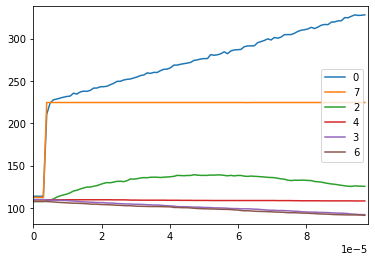

In [9]:
kmc_boltz.plot_top_n_states(6)

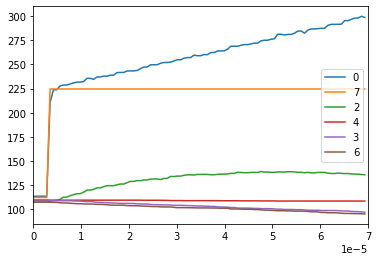

In [10]:
plot_top_n_states(
    trajectories,
    n_show=6,
    total_states=len(kmc_boltz.get_state_dict_at_time_as_pandas(0.00007)),
    resolution=0.00007/100,
    max_time=0.00007
)

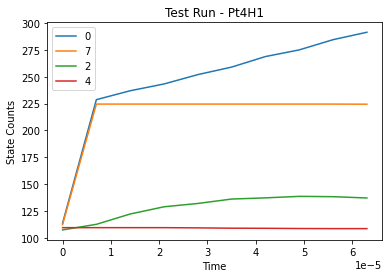

In [11]:
plot_states(
    trajectories,
    states_to_plot=[0, 7, 2, 4],
    resolution=0.00007/10,
    total_states=len(kmc_boltz.get_state_dict_at_time_as_pandas(0.00007)),
    max_time=0.00007,
    title="Test Run - Pt4H1",
    xlabel="Time",
    ylabel="State Counts",
    save=False,
    save_name="../../reporting/plots/test_run_Pt4H1.png",
)

In [12]:
kmc_boltz.plot_top_n_states_stacked(
    n_show = -1,
    resolution=None, 
    max_time=None, 
    title=None, 
    save=True, 
    save_name="props.png") # -1 shows all states

In [13]:
kmc_boltz.plot_select_states_stacked(
    states_to_plot=[0, 7, 2, 4],
    resolution=None, 
    max_time=None, 
    title=None, 
    save=True, 
    save_name="props.png") # -1 shows all states

[0, 1, 2, 3, 6, 4, 5, 8, 7, 9]
[1594, 4472, 356, 176, 962, 15, 218, 0, 2207, 0]


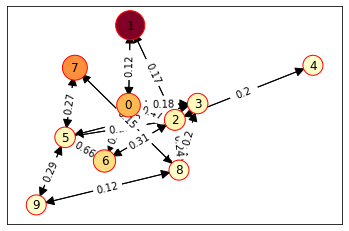

In [16]:
time_slice = 0
pos = graph_trajectories_static(
    trajectories=trajectories, energies=energies_mat, time=0.001, ret_pos=True
)